# Salmonella Newport USA population analysis

In [77]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from PIL import Image
import io
pd.set_option('display.max_columns', 300)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [69]:
# Import MLST output 
file1 = 'salmonellast_output.csv'
data1 = pd.read_csv(file1, header=0, na_values='Nothing')
# Split the name column into two to get the SRR ids
data1['id'] = data1['FILE'].str.split('_').str[0]
# Filter out undesirable columns
data2 = data1.drop(['FILE', 'SCHEME'], axis = 1)

In [70]:
# Import SISTR output
file2 = 'sistr_output.csv'
data3 = pd.read_csv(file2, header=0, na_values='Nothing')
# Remove columns that are not neeed
list_of_cols = ['cgmlst_distance', 'cgmlst_genome_match', 'cgmlst_matching_alleles', 'cgmlst_subspecies', 'fasta_filepath',
               'h1', 'h2', 'o_antigen', 'qc_messages', 'serogroup']
data4 = data3.drop(columns = list_of_cols, axis = 1)
# Split the name columnn to create the id column
data4['id'] = data4['genome'].str.split('_').str[0]
data4 = data4.drop('genome', axis = 1)

In [71]:
# Import BAPS output 
file3 = 'fastbaps_partition_baps_prior_l6.csv'
data5 = pd.read_csv(file3, header=0, na_values='Nothing')
data5 = data5.rename(columns = {"Isolates":"id", "Level 1":"Baps_1", "Level 2":"Baps_2", 
                                "Level 3":"Baps_3", "Level 4":"Baps_4", "Level 5":"Baps_5", "Level 6":"Baps_6"})

In [72]:
# Merge all datasets based on SRR id
data6 = pd.merge(data2, data4, on = 'id')
data7 = pd.merge(data5, data6, on = 'id')

In [73]:
# Clean data
# Replace hyphen with NA
data7 = data7.replace('-', np.nan)
# Replace interrogation characters with NA
data7 = data7.replace('?', np.nan)
# Filter data7 by serovar to eliminate the misclassified serovars based on SISTR
data8 = data7[data7['serovar'] == 'Newport']

# PLOTS

<ipython-input-74-50730b25dece>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data8['ST'] = data8['ST'].replace('-', np.nan)
<ipython-input-74-50730b25dece>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data8['ST'] = pd.to_numeric(data8['ST'])
<ipython-input-74-50730b25dece>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

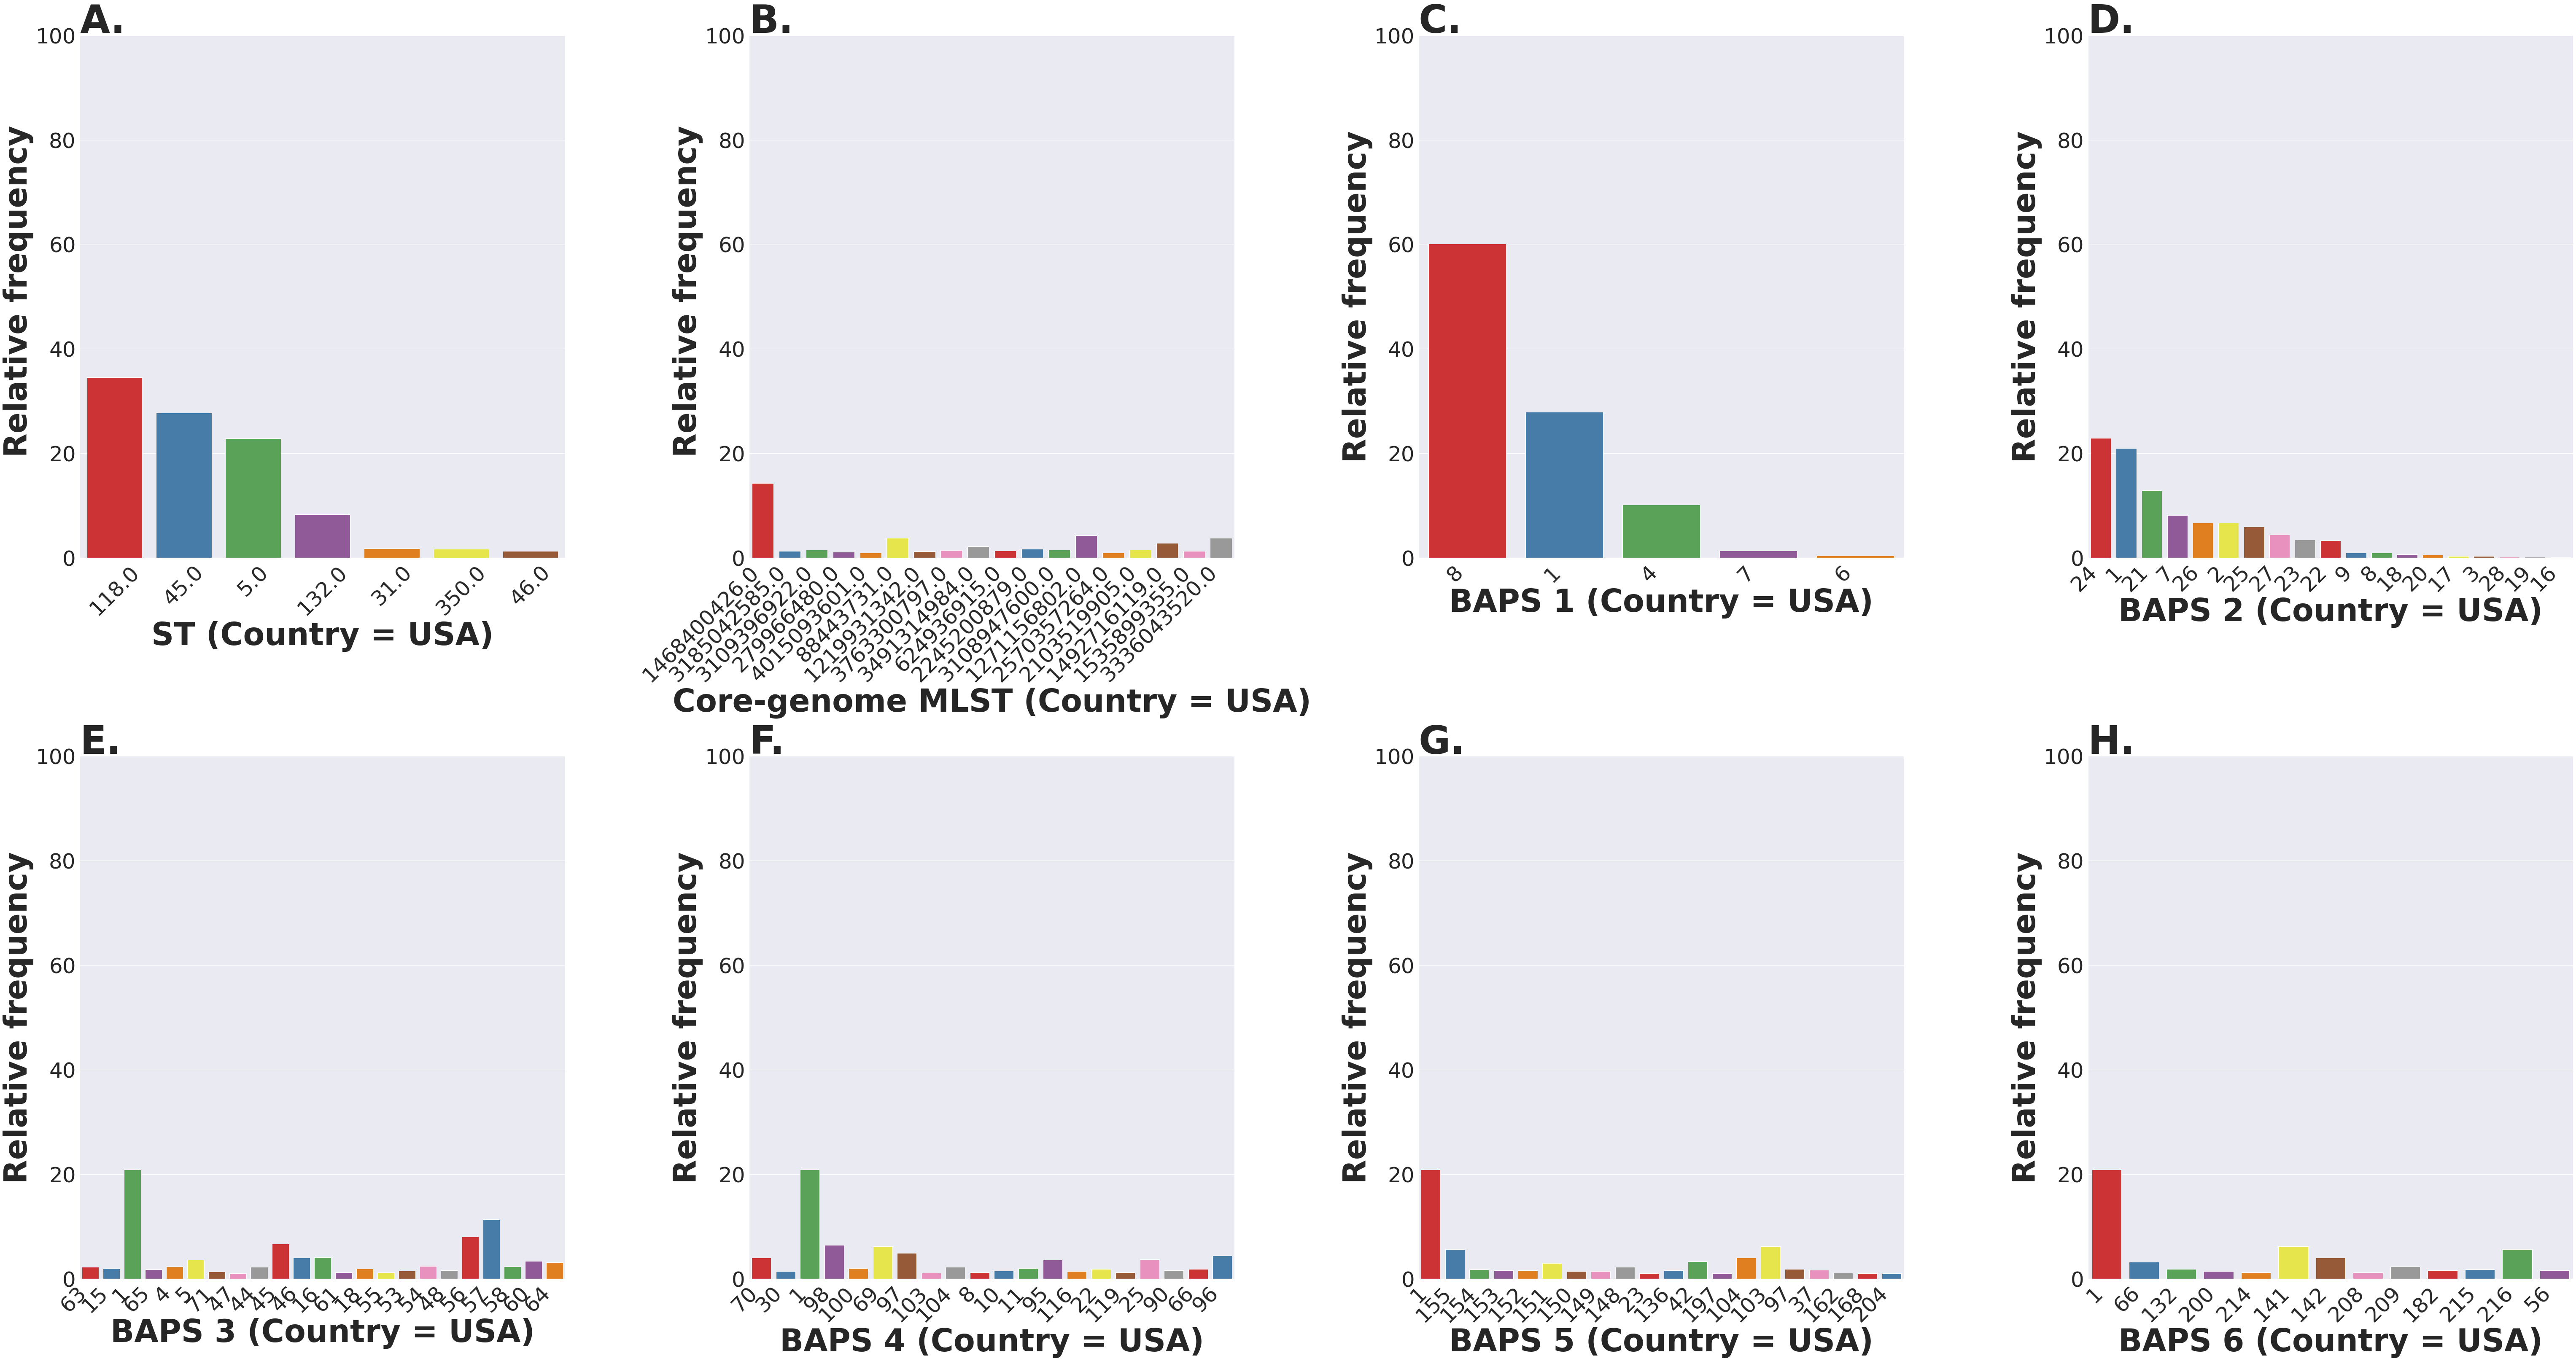

In [74]:
# Set background and number of subplots 

_ = sns.set(style="darkgrid")
fig, ax = plt.subplots(2, 4, figsize=(85, 45))

# Remove default tick marks and labels 

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

############################################################################################################

# Plot the ST distribution (We are filtering relative frequencies >= 1%)

ax1 = fig.add_subplot(2, 4, 1)
_ = sns.set_palette('Set1', 10)

# I make sure NAs are not impacting the plot
data8['ST'] = data8['ST'].replace('-', np.nan)
data8['ST'] = pd.to_numeric(data8['ST'])
a = data8['ST'].value_counts(dropna = True, normalize = True)*100
df1 = pd.DataFrame(data = a.index, columns = ['ST'])
df2 = pd.DataFrame(data = a.values, columns = ['frequency'])
df = pd.merge(df1, df2, left_index = True, right_index = True)
df3 = df[df['frequency'] >= 1]
_ = sns.barplot(x = df3['ST'], y = df3['frequency'], order = (df3['ST'].value_counts(ascending = True).index))
_ = ax1.set_xlabel('ST (Country = USA)', fontsize = 74, weight = 'bold')
_ = ax1.set_ylabel(' Relative frequency', fontsize = 74, weight = 'bold')
_ = ax1.tick_params(axis = 'x', which = 'major', labelsize = 50, labelrotation = 45)
_ = ax1.tick_params(axis = 'y', which = 'major', labelsize = 50)
_ = ax1.set_ylim([0,100])
_ = ax1.set_title('A.', fontsize = 92, weight = 'bold', loc = 'left')

##############################################################################################################

# Plot the core-genome MLST distribution (We are filtering relative frequencies >= 1%)

ax2 = fig.add_subplot(2, 4, 2)
_ = sns.set_palette('Set1', 30)
data8['cgmlst_ST'] = data8['cgmlst_ST'].replace('-', np.nan)
data8['cgmlst_ST'] = pd.to_numeric(data8['cgmlst_ST'])
ab = data8['cgmlst_ST'].value_counts(dropna = True, normalize = True)*100
df1a = pd.DataFrame(data = ab.index, columns = ['cgmlst_ST'])
df2a = pd.DataFrame(data = ab.values, columns = ['frequency'])
df = pd.merge(df1a, df2a, left_index = True, right_index = True)
df3a = df[df['frequency'] >= 1]
_ = sns.barplot(x = df3a['cgmlst_ST'], y = df3a['frequency'], order = (df3a['cgmlst_ST'].value_counts(ascending = True).index))
_ = ax2.set_xlabel('Core-genome MLST (Country = USA)', fontsize = 74, weight = 'bold')
_ = ax2.set_ylabel(' Relative frequency', fontsize = 74, weight = 'bold')
_ = ax2.tick_params(axis = 'x', which = 'major', labelsize = 50, labelrotation = 45)
_ = ax2.tick_params(axis = 'y', which = 'major', labelsize = 50)
_ = ax2.set_ylim([0,100])
_ = plt.xticks(horizontalalignment='right')
_ = ax2.set_title('B.', fontsize = 92, weight = 'bold', loc = 'left')

############################################################################################

# Plot the Baps 1 distribution 

ax3 = fig.add_subplot(2, 4, 3)
_ = sns.set_palette('Set1', 30)
_ = sns.barplot(x = 'Baps_1', y = 'Baps_1', data = data8,  estimator = lambda x: len(x) / len(data8) * 100,
               order=(data8['Baps_1'].value_counts().index))
_ = ax3.set_xlabel('BAPS 1 (Country = USA)', fontsize = 74, weight = 'bold')
_ = ax3.set_ylabel('Relative frequency', fontsize = 74, weight = 'bold')
_ = ax3.tick_params(axis = 'x', which = 'major', labelsize = 50, labelrotation = 45)
_ = ax3.tick_params(axis = 'y', which = 'major', labelsize = 50)
_ = ax3.set_ylim([0,100])
_ = plt.xticks(horizontalalignment='right')
_ = ax3.set_title('C.', fontsize = 92, weight = 'bold', loc = 'left')

############################################################################################

# Plot the Baps 2 distribution 

ax4 = fig.add_subplot(2, 4, 4)
_ = sns.set_palette('Set1', 30)
_ = sns.barplot(x = 'Baps_2', y = 'Baps_2', data = data8,  estimator = lambda x: len(x) / len(data8) * 100,
               order=(data8['Baps_2'].value_counts().index))
_ = ax4.set_xlabel('BAPS 2 (Country = USA)', fontsize = 74, weight = 'bold')
_ = ax4.set_ylabel('Relative frequency', fontsize = 74, weight = 'bold')
_ = ax4.tick_params(axis = 'x', which = 'major', labelsize = 50, labelrotation = 45)
_ = ax4.tick_params(axis = 'y', which = 'major', labelsize = 50)
_ = ax4.set_ylim([0,100])
_ = plt.xticks(horizontalalignment='right')
_ = ax4.set_title('D.', fontsize = 92, weight = 'bold', loc = 'left')

############################################################################################

# Plot the Baps 3 distribution (We are filtering relative frequencies >= 1%)

ax5 = fig.add_subplot(2, 4, 5)
_ = sns.set_palette('Set1', 60)
a = data8['Baps_3'].value_counts(normalize = True)*100
df1 = pd.DataFrame(data=a.index, columns=['Baps_3'])
df2 = pd.DataFrame(data=a.values, columns=['frequency'])
df = pd.merge(df1, df2, left_index=True, right_index=True)
df3 = df[df['frequency'] >= 1]
_ = sns.barplot(x = 'Baps_3', y = 'frequency', data = df3,
               order=(df3['Baps_3'].value_counts().index))
_ = ax5.set_xlabel('BAPS 3 (Country = USA)', fontsize = 74, weight = 'bold')
_ = ax5.set_ylabel('Relative frequency', fontsize = 74, weight = 'bold')
_ = ax5.tick_params(axis = 'x', which = 'major', labelsize = 50, labelrotation = 45)
_ = ax5.tick_params(axis = 'y', which = 'major', labelsize = 50)
_ = ax5.set_ylim([0,100])
_ = plt.xticks(horizontalalignment='right')
_ = ax5.set_title('E.', fontsize = 92, weight = 'bold', loc = 'left')

############################################################################################

# Plot the Baps 4 distribution (We are filtering relative frequencies >= 1%)

ax6 = fig.add_subplot(2, 4, 6)
_ = sns.set_palette('Set1', 60)
a = data8['Baps_4'].value_counts(normalize = True)*100
df1 = pd.DataFrame(data=a.index, columns=['Baps_4'])
df2 = pd.DataFrame(data=a.values, columns=['frequency'])
df = pd.merge(df1, df2, left_index=True, right_index=True)
df3 = df[df['frequency'] >= 1]
_ = sns.barplot(x = 'Baps_4', y = 'frequency', data = df3,
               order=(df3['Baps_4'].value_counts().index))
_ = ax6.set_xlabel('BAPS 4 (Country = USA)', fontsize = 74, weight = 'bold')
_ = ax6.set_ylabel('Relative frequency', fontsize = 74, weight = 'bold')
_ = ax6.tick_params(axis = 'x', which = 'major', labelsize = 50, labelrotation = 45)
_ = ax6.tick_params(axis = 'y', which = 'major', labelsize = 50)
_ = ax6.set_ylim([0,100])
_ = plt.xticks(horizontalalignment='right')
_ = ax6.set_title('F.', fontsize = 92, weight = 'bold', loc = 'left')

############################################################################################

# Plot the Baps 5 distribution (We are filtering relative frequencies >= 1%)

ax7 = fig.add_subplot(2, 4, 7)
_ = sns.set_palette('Set1', 30)
a = data8['Baps_5'].value_counts(normalize = True)*100
df1 = pd.DataFrame(data=a.index, columns=['Baps_5'])
df2 = pd.DataFrame(data=a.values, columns=['frequency'])
df = pd.merge(df1, df2, left_index=True, right_index=True)
df3 = df[df['frequency'] >= 1]
_ = sns.barplot(x = 'Baps_5', y = 'frequency', data = df3,
               order=(df3['Baps_5'].value_counts(ascending = True).index))
_ = ax7.set_xlabel('BAPS 5 (Country = USA)', fontsize = 74, weight = 'bold')
_ = ax7.set_ylabel('Relative frequency', fontsize = 74, weight = 'bold')
_ = ax7.tick_params(axis = 'x', which = 'major', labelsize = 50, labelrotation = 45)
_ = ax7.tick_params(axis = 'y', which = 'major', labelsize = 50)
_ = ax7.set_ylim([0,100])
_ = plt.xticks(horizontalalignment='right')
_ = ax7.set_title('G.', fontsize = 92, weight = 'bold', loc = 'left')

############################################################################################

# Plot the Baps 6 distribution (We are filtering relative frequencies >= 1%)

ax8 = fig.add_subplot(2, 4, 8)
_ = sns.set_palette('Set1', 30)
a = data8['Baps_6'].value_counts(normalize = True)*100
df1 = pd.DataFrame(data=a.index, columns=['Baps_6'])
df2 = pd.DataFrame(data=a.values, columns=['frequency'])
df = pd.merge(df1, df2, left_index=True, right_index=True)
df3 = df[df['frequency'] >= 1]
_ = sns.barplot(x = 'Baps_6', y = 'frequency', data = df3,
               order=(df3['Baps_6'].value_counts(ascending = True).index))
_ = ax8.set_xlabel('BAPS 6 (Country = USA)', fontsize = 74, weight = 'bold')
_ = ax8.set_ylabel('Relative frequency', fontsize = 74, weight = 'bold')
_ = ax8.tick_params(axis = 'x', which = 'major', labelsize = 50, labelrotation = 45)
_ = ax8.tick_params(axis = 'y', which = 'major', labelsize = 50)
_ = ax8.set_ylim([0,100])
_ = plt.xticks(horizontalalignment='right')
_ = ax8.set_title('H.', fontsize = 92, weight = 'bold', loc = 'left')

# Put a tight layout to organize the panel display evenly

_ = fig.tight_layout()

# Save figure 

#plt.savefig('Figure1.png', bbox_inches='tight')

# Save the image in memory in PNG format
png1 = io.BytesIO()
fig.savefig(png1, format="png")

# Load this image into PIL
png2 = Image.open(png1)

# Save as TIFF
png2.save("Figure_4.tiff")
png1.close()

**Figure 4.** ***Salmonella* Newport (USA) population stratification by haplotype classification using two methods: allelic calls (ST and cgMLST) and a heuristic Bayesian approach (BAPS)**. 
(A) ST distribution based on seven ubiquitous and genome-scattered loci using the MLST program, which is based on the PubMLST typing schemes (plot excludes STs with relative frequency below 1%). (B) Core-genome MLST distribution based on SISTR which uses ~330 ubiquitous loci (plot excludes STs with relative frequency below 1%). (C-H) BAPS levels 1-6 relative frequencies. For BAPS levels 3-6, we have excluded sub-groups that were below 1% in relative frequency in order to facilitate visualization. The initial number of genomes used as an input was 2,392, while these analyses were run with 2,365 genomes that passed the post-assembly filtering steps.

<ipython-input-75-a9d01dba2020>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data9['ST'] = data9['ST'].replace('-', np.nan)
<ipython-input-75-a9d01dba2020>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data9['ST'] = pd.to_numeric(data9['ST'])
<ipython-input-75-a9d01dba2020>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

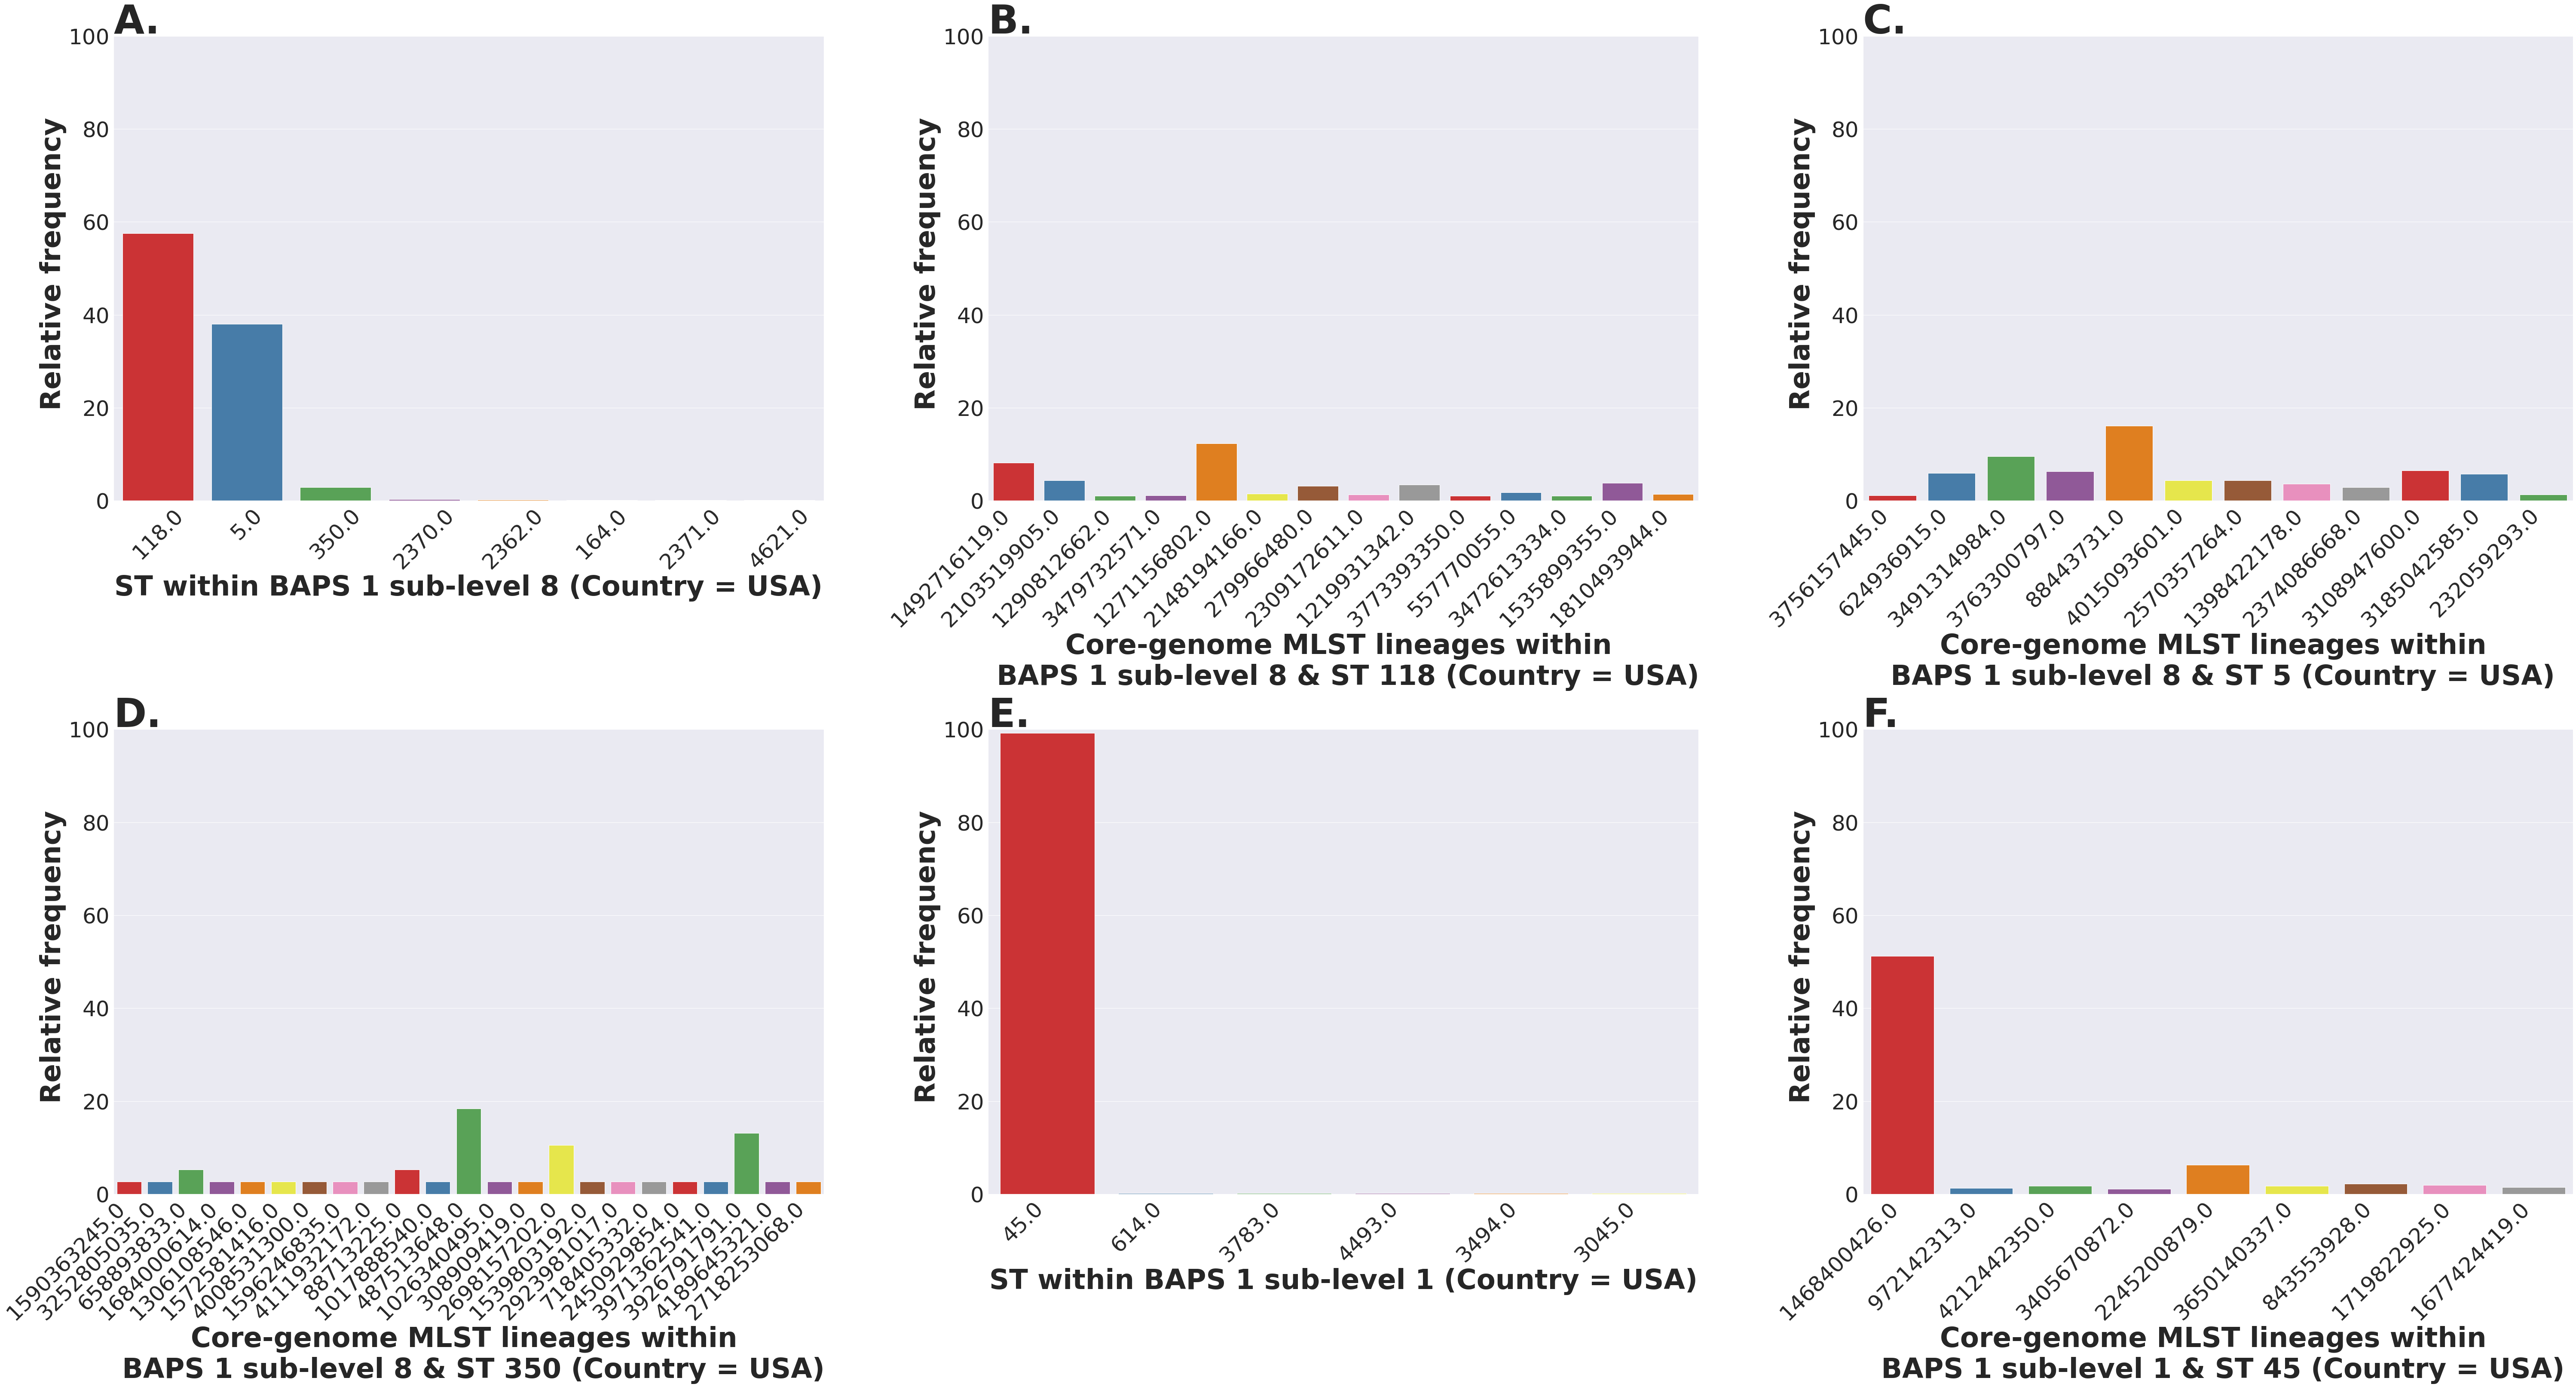

In [75]:
# Depicting the hierarchical structure of the population 

# Set background and number of subplots 

_ = sns.set(style="darkgrid")
fig, ax = plt.subplots(2, 3, figsize=(85, 45))

# Remove default tick marks and labels 

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

##############################################################################################################

# Filter Baps1|sub-level 8, display the ST distribution, and then filter the most dominant ST and display of cgmlst_ST distribution

ax1 = fig.add_subplot(2, 3, 1)
_ = sns.set_palette('Set1', 20)

# Filtering STs above 0.1% of relative frequency

data9 = data8[data8['Baps_1'] == 8]
data9['ST'] = data9['ST'].replace('-', np.nan)
data9['ST'] = pd.to_numeric(data9['ST'])
a = data9['ST'].value_counts(dropna = True, normalize = True)*100
df1 = pd.DataFrame(data = a.index, columns = ['ST'])
df2 = pd.DataFrame(data = a.values, columns = ['frequency'])
df = pd.merge(df1, df2, left_index = True, right_index = True)
df3 = df[df['frequency'] >= 0.1]
_ = sns.barplot(x = df3['ST'], y = df3['frequency'], order = (df3['ST'].value_counts(ascending = True).index))
_ = ax1.set_xlabel('ST within BAPS 1 sub-level 8 (Country = USA)', fontsize = 64, weight = 'bold')
_ = ax1.set_ylabel(' Relative frequency', fontsize = 64, weight = 'bold')
_ = ax1.tick_params(axis = 'x', which = 'major', labelsize = 50, labelrotation = 45)
_ = ax1.tick_params(axis = 'y', which = 'major', labelsize = 50)
_ = ax1.set_ylim([0,100])
_ = ax1.set_title('A.', fontsize = 92, weight = 'bold', loc = 'left')

# Filter Baps1|sub-level 8|ST118 and display of cgmlst_ST distribution

ax1 = fig.add_subplot(2, 3, 2)
_ = sns.set_palette('Set1', 20)

# Filtering cgmlst_STs above 1% of relative frequency

data10 = data9[data9['ST'] == 118]
data10['cgmlst_ST'] = data9['cgmlst_ST'].replace('-', np.nan)
data10['cgmlst_ST'] = pd.to_numeric(data10['cgmlst_ST'])
a = data10['cgmlst_ST'].value_counts(dropna = True, normalize = True)*100
df1 = pd.DataFrame(data = a.index, columns = ['cgmlst_ST'])
df2 = pd.DataFrame(data = a.values, columns = ['frequency'])
df = pd.merge(df1, df2, left_index = True, right_index = True)
df3 = df[df['frequency'] >= 1]
_ = sns.barplot(x = df3['cgmlst_ST'], y = df3['frequency'], order = (df3['cgmlst_ST'].value_counts(ascending = True).index))
_ = ax1.set_xlabel('Core-genome MLST lineages within \n BAPS 1 sub-level 8 & ST 118 (Country = USA)', fontsize = 64, weight = 'bold')
_ = ax1.set_ylabel(' Relative frequency', fontsize = 64, weight = 'bold')
_ = ax1.tick_params(axis = 'x', which = 'major', labelsize = 50, labelrotation = 45)
_ = ax1.tick_params(axis = 'y', which = 'major', labelsize = 50)
_ = ax1.set_ylim([0,100])
_ = plt.xticks(horizontalalignment='right')
_ = ax1.set_title('B.', fontsize = 92, weight = 'bold', loc = 'left')

##############################################################################################################

# Filter Baps1|sub-level 8|ST5 and display of cgmlst_ST distribution

ax1 = fig.add_subplot(2, 3, 3)
_ = sns.set_palette('Set1', 20)

# Filtering cgmlst_STs above 1% of relative frequency

data10 = data9[data9['ST'] == 5]
data10['cgmlst_ST'] = data9['cgmlst_ST'].replace('-', np.nan)
data10['cgmlst_ST'] = pd.to_numeric(data10['cgmlst_ST'])
a = data10['cgmlst_ST'].value_counts(dropna = True, normalize = True)*100
df1 = pd.DataFrame(data = a.index, columns = ['cgmlst_ST'])
df2 = pd.DataFrame(data = a.values, columns = ['frequency'])
df = pd.merge(df1, df2, left_index = True, right_index = True)
df3 = df[df['frequency'] >= 1]
_ = sns.barplot(x = df3['cgmlst_ST'], y = df3['frequency'], order = (df3['cgmlst_ST'].value_counts(ascending = True).index))
_ = ax1.set_xlabel('Core-genome MLST lineages within \n BAPS 1 sub-level 8 & ST 5 (Country = USA)', fontsize = 64, weight = 'bold')
_ = ax1.set_ylabel(' Relative frequency', fontsize = 64, weight = 'bold')
_ = ax1.tick_params(axis = 'x', which = 'major', labelsize = 50, labelrotation = 45)
_ = ax1.tick_params(axis = 'y', which = 'major', labelsize = 50)
_ = ax1.set_ylim([0,100])
_ = plt.xticks(horizontalalignment='right')
_ = ax1.set_title('C.', fontsize = 92, weight = 'bold', loc = 'left')

##############################################################################################################

# Filter Baps1|sub-level 8|ST350 and display of cgmlst_ST distribution

ax1 = fig.add_subplot(2, 3, 4)
_ = sns.set_palette('Set1', 40)

# Filtering cgmlst_STs above 1% of relative frequency

data10 = data9[data9['ST'] == 350]
data10['cgmlst_ST'] = data9['cgmlst_ST'].replace('-', np.nan)
data10['cgmlst_ST'] = pd.to_numeric(data10['cgmlst_ST'])
a = data10['cgmlst_ST'].value_counts(dropna = True, normalize = True)*100
df1 = pd.DataFrame(data = a.index, columns = ['cgmlst_ST'])
df2 = pd.DataFrame(data = a.values, columns = ['frequency'])
df = pd.merge(df1, df2, left_index = True, right_index = True)
df3 = df[df['frequency'] >= 1]
_ = sns.barplot(x = df3['cgmlst_ST'], y = df3['frequency'], order = (df3['cgmlst_ST'].value_counts(ascending = True).index))
_ = ax1.set_xlabel('Core-genome MLST lineages within \n BAPS 1 sub-level 8 & ST 350 (Country = USA)', fontsize = 64, weight = 'bold')
_ = ax1.set_ylabel(' Relative frequency', fontsize = 64, weight = 'bold')
_ = ax1.tick_params(axis = 'x', which = 'major', labelsize = 50, labelrotation = 45)
_ = ax1.tick_params(axis = 'y', which = 'major', labelsize = 50)
_ = ax1.set_ylim([0,100])
_ = plt.xticks(horizontalalignment='right')
_ = ax1.set_title('D.', fontsize = 92, weight = 'bold', loc = 'left')

##############################################################################################################

# Filter Baps1|sub-level 1, display the ST distribution, and then filter the most dominant ST and display of cgmlst_ST distribution

ax1 = fig.add_subplot(2, 3, 5)
_ = sns.set_palette('Set1', 20)

# Filtering STs above 0.1% of relative frequency

data9 = data8[data8['Baps_1'] == 1]
data9['ST'] = data9['ST'].replace('-', np.nan)
data9['ST'] = pd.to_numeric(data9['ST'])
a = data9['ST'].value_counts(dropna = True, normalize = True)*100
df1 = pd.DataFrame(data = a.index, columns = ['ST'])
df2 = pd.DataFrame(data = a.values, columns = ['frequency'])
df = pd.merge(df1, df2, left_index = True, right_index = True)
df3 = df[df['frequency'] >= 0.1]
_ = sns.barplot(x = df3['ST'], y = df3['frequency'], order = (df3['ST'].value_counts(ascending = True).index))
_ = ax1.set_xlabel('ST within BAPS 1 sub-level 1 (Country = USA)', fontsize = 64, weight = 'bold')
_ = ax1.set_ylabel(' Relative frequency', fontsize = 64, weight = 'bold')
_ = ax1.tick_params(axis = 'x', which = 'major', labelsize = 50, labelrotation = 45)
_ = ax1.tick_params(axis = 'y', which = 'major', labelsize = 50)
_ = ax1.set_ylim([0,100])
_ = plt.xticks(horizontalalignment='right')
_ = ax1.set_title('E.', fontsize = 92, weight = 'bold', loc = 'left')

##############################################################################################################

# Filter Baps1|sub-level 1|ST45 and display of cgmlst_ST distribution

ax1 = fig.add_subplot(2, 3, 6)
_ = sns.set_palette('Set1', 40)

# Filtering cgmlst_STs above 1% of relative frequency

data10 = data9[data9['ST'] == 45]
data10['cgmlst_ST'] = data9['cgmlst_ST'].replace('-', np.nan)
data10['cgmlst_ST'] = pd.to_numeric(data10['cgmlst_ST'])
a = data10['cgmlst_ST'].value_counts(dropna = True, normalize = True)*100
df1 = pd.DataFrame(data = a.index, columns = ['cgmlst_ST'])
df2 = pd.DataFrame(data = a.values, columns = ['frequency'])
df = pd.merge(df1, df2, left_index = True, right_index = True)
df3 = df[df['frequency'] >= 1]
_ = sns.barplot(x = df3['cgmlst_ST'], y = df3['frequency'], order = (df3['cgmlst_ST'].value_counts(ascending = True).index))
_ = ax1.set_xlabel('Core-genome MLST lineages within \n BAPS 1 sub-level 1 & ST 45 (Country = USA)', fontsize = 64, weight = 'bold')
_ = ax1.set_ylabel(' Relative frequency', fontsize = 64, weight = 'bold')
_ = ax1.tick_params(axis = 'x', which = 'major', labelsize = 50, labelrotation = 45)
_ = ax1.tick_params(axis = 'y', which = 'major', labelsize = 50)
_ = ax1.set_ylim([0,100])
_ = plt.xticks(horizontalalignment='right')
_ = ax1.set_title('F.', fontsize = 92, weight = 'bold', loc = 'left')

# Put a tight layout to organize the panel display evenly

_ = fig.tight_layout()

# Save figure 

#plt.savefig('Figure2.png', bbox_inches='tight')

# Save the image in memory in PNG format
png1 = io.BytesIO()
fig.savefig(png1, format="png")

# Load this image into PIL
png2 = Image.open(png1)

# Save as TIFF
png2.save("Figure_S1.tiff")
png1.close()

**Figure S1.** ***Salmonella* Newport (USA) hierarchical population-based analysis**. 
(A) ST distribution with BAPS level 1 sub-level 8 (excluding STs with relative frequency below 0.1%). (B) Core-genome MLST lineage distribution within BAPS level 1 sub-level 8 and ST118 (excluding lineages with relative frequency below 1%). (C) Core-genome MLST lineage distribution within BAPS level 1 sub-level 8 and ST5 (excluding lineages with relative frequency below 1%). (D) Core-genome MLST lineage distribution within BAPS level 1 sub-level 8 and ST350 (excluding lineages with relative frequency below 1%). (E) ST distribution with BAPS level 1 sub-level 1 (excluding STs with relative frequency below 0.1%). (F) Core-genome MLST lineage distribution within BAPS level 1 sub-level 1 and ST45 (excluding lineages with relative frequency below 1%). The number of filtered genomes (i.e. genomes that passed assembly quality control metrics) used as an input in this analysis was 2,365. 

<ipython-input-76-85bd1914756e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data8['lineage'] = data8['cgmlst_ST'].apply(lambda x: 1 if x == 1468400426 else 0)


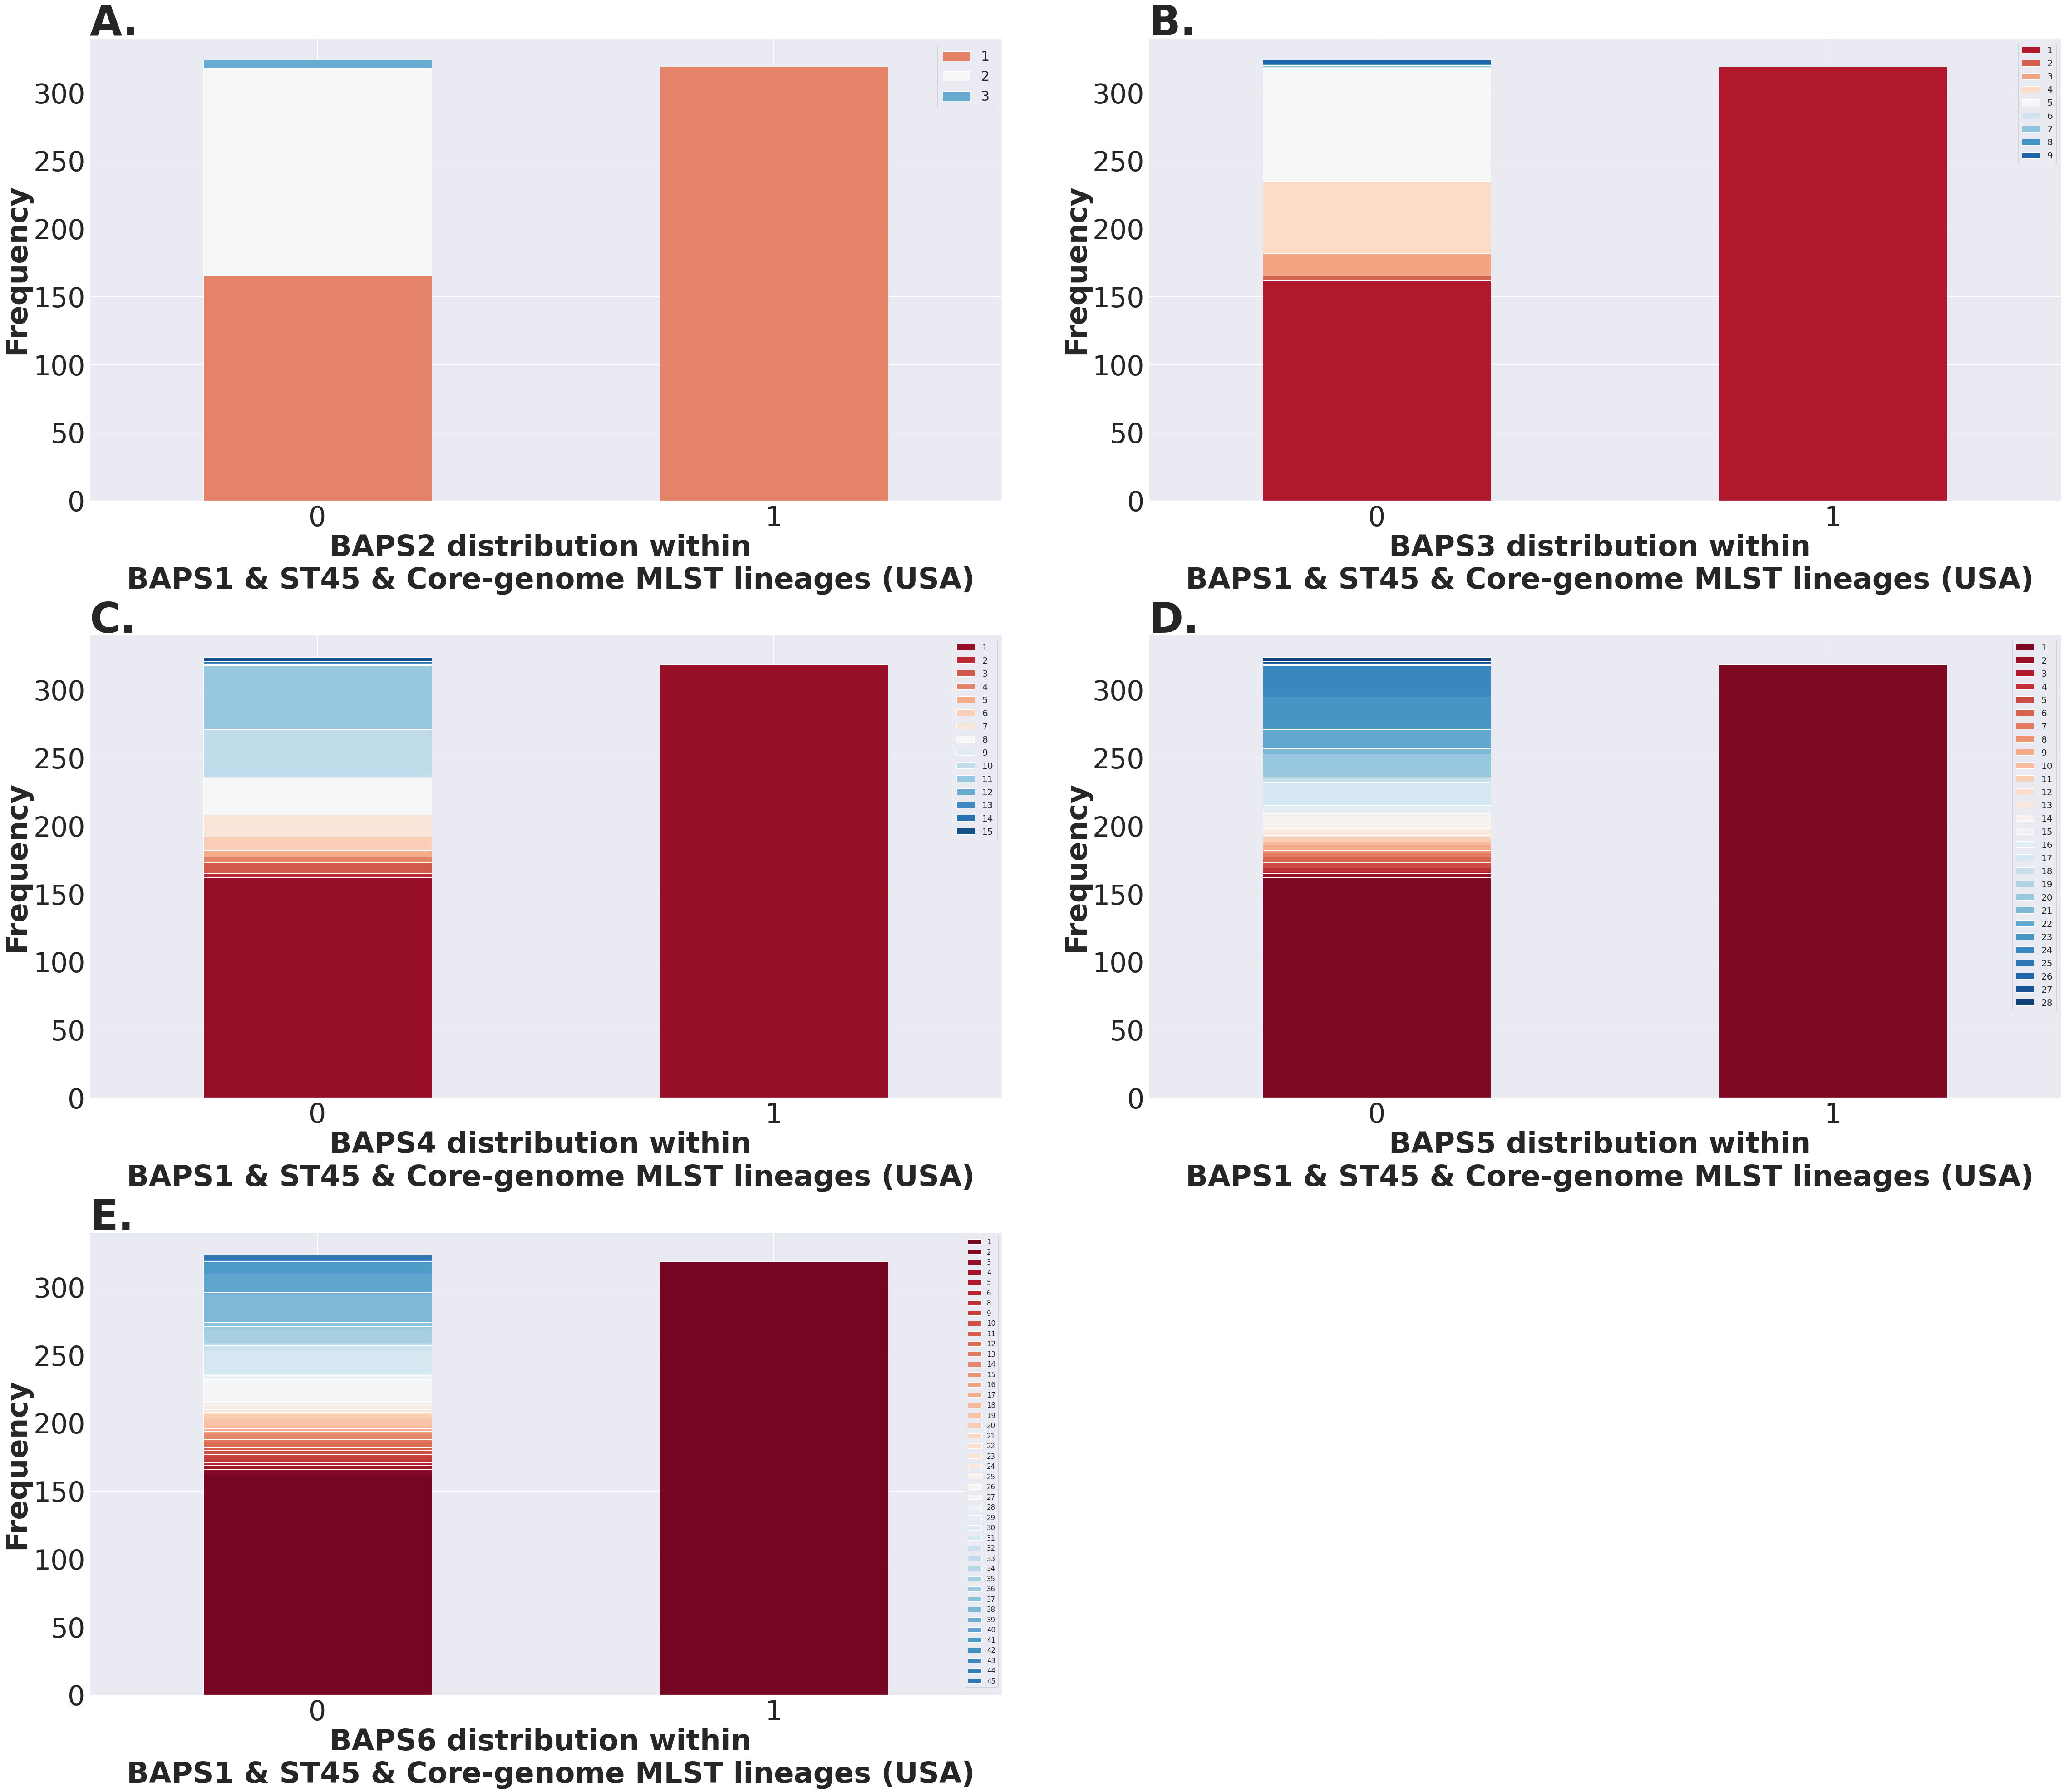

In [76]:
# Plot the haplotype variation for Baps1 & ST45 & core-genome mlst 1468400426.0 vs. others 

# Set background and number of subplots 

_ = sns.set(style="darkgrid")
fig, ax = plt.subplots(3, 2, figsize=(65, 55))

# Remove default tick marks and labels 

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

##############################################################################################################

# Let's create a column that produces a binary call (1 if cgmlst_ST is 1468400426.0 and if else 0)

data8['lineage'] = data8['cgmlst_ST'].apply(lambda x: 1 if x == 1468400426 else 0)

# Let's now sort Baps 1 and ST 45

data9 = data8.loc[(data8['Baps_1'] == 1) & (data8['ST'] == 45)]

ax1 = fig.add_subplot(3, 2, 1)
sns.set_palette("RdBu", 3)
baps_st = pd.crosstab(data9['lineage'], data9['Baps_2'])
_ = baps_st.plot.bar(stacked=True, ax = ax1)
_ = ax1.set_xlabel('BAPS2 distribution within \n BAPS1 & ST45 & Core-genome MLST lineages (USA)', fontsize = 64, weight = 'bold')
_ = ax1.set_ylabel('Frequency', fontsize = 64, weight = 'bold')
_ = ax1.tick_params(axis = 'x', which = 'major', labelsize = 60, labelrotation = 0)
_ = ax1.tick_params(axis = 'y', which = 'major', labelsize = 60)
_ = ax1.set_title('A.', fontsize = 92, weight = 'bold', loc = 'left')
plt.legend(fontsize = 30)

ax2 = fig.add_subplot(3, 2, 2)
sns.set_palette("RdBu", 9)
baps_st = pd.crosstab(data9['lineage'], data9['Baps_3'])
_ = baps_st.plot.bar(stacked=True, ax = ax2)
_ = ax2.set_xlabel('BAPS3 distribution within \n BAPS1 & ST45 & Core-genome MLST lineages (USA)', fontsize = 64, weight = 'bold')
_ = ax2.set_ylabel('Frequency', fontsize = 64, weight = 'bold')
_ = ax2.tick_params(axis = 'x', which = 'major', labelsize = 60, labelrotation = 0)
_ = ax2.tick_params(axis = 'y', which = 'major', labelsize = 60)
_ = ax2.set_title('B.', fontsize = 92, weight = 'bold', loc = 'left')
plt.legend(fontsize = 20)

ax3 = fig.add_subplot(3, 2, 3)
sns.set_palette("RdBu", 15)
baps_st = pd.crosstab(data9['lineage'], data9['Baps_4'])
_ = baps_st.plot.bar(stacked=True, ax = ax3)
_ = ax3.set_xlabel('BAPS4 distribution within \n BAPS1 & ST45 & Core-genome MLST lineages (USA)', fontsize = 64, weight = 'bold')
_ = ax3.set_ylabel('Frequency', fontsize = 64, weight = 'bold')
_ = ax3.tick_params(axis = 'x', which = 'major', labelsize = 60, labelrotation = 0)
_ = ax3.tick_params(axis = 'y', which = 'major', labelsize = 60)
_ = ax3.set_title('C.', fontsize = 92, weight = 'bold', loc = 'left')
plt.legend(fontsize = 20)

ax4 = fig.add_subplot(3, 2, 4)
sns.set_palette("RdBu", 28)
baps_st = pd.crosstab(data9['lineage'], data9['Baps_5'])
_ = baps_st.plot.bar(stacked=True, ax = ax4)
_ = ax4.set_xlabel('BAPS5 distribution within \n BAPS1 & ST45 & Core-genome MLST lineages (USA)', fontsize = 64, weight = 'bold')
_ = ax4.set_ylabel('Frequency', fontsize = 64, weight = 'bold')
_ = ax4.tick_params(axis = 'x', which = 'major', labelsize = 60, labelrotation = 0)
_ = ax4.tick_params(axis = 'y', which = 'major', labelsize = 60)
_ = ax4.set_title('D.', fontsize = 92, weight = 'bold', loc = 'left')
plt.legend(fontsize = 20)

ax5 = fig.add_subplot(3, 2, 5)
sns.set_palette("RdBu", 50)
baps_st = pd.crosstab(data9['lineage'], data9['Baps_6'])
_ = baps_st.plot.bar(stacked=True, ax = ax5)
_ = ax5.set_xlabel('BAPS6 distribution within \n BAPS1 & ST45 & Core-genome MLST lineages (USA)', fontsize = 64, weight = 'bold')
_ = ax5.set_ylabel('Frequency', fontsize = 64, weight = 'bold')
_ = ax5.tick_params(axis = 'x', which = 'major', labelsize = 60, labelrotation = 0)
_ = ax5.tick_params(axis = 'y', which = 'major', labelsize = 60)
_ = ax5.set_title('E.', fontsize = 92, weight = 'bold', loc = 'left')

plt.legend(fontsize = 15)

# Put a tight layout to organize the panel display evenly

_ = fig.tight_layout()

# Remove the last plot

ax.flat[-1].set_visible(False)

# Save figure 

#plt.savefig('Figure3.png', bbox_inches='tight')

# Save the image in memory in PNG format
png1 = io.BytesIO()
fig.savefig(png1, format="png")

# Load this image into PIL
png2 = Image.open(png1)

# Save as TIFF
png2.save("Figure_S2.tiff")
png1.close()

**Figure S2.** **BAPS levels 2-6 frequency of core-genome MLST lineages with BAPS level 1 and ST45 within S. Newport.** 
First, core genome MLST (cgMLST) genotypes were classified as 1 if it were cgMLST 1468400426, and 0 otherwise. cgMLST 1468400426 can be called a major epidemiological clone (i.e. higher relative frequency) within BAPS level 1 and ST45. The goal was to compare the distribution of BAPS levels 2-6 between cgMLST 1468400426 or the other epidemiological clones as a sub-population of BAPS level 1 and ST45. (A-E) Frequency of BAPS levels 2-6, respectively, when comparing group classified as 1 (core genome MLST = 1468400426) or 0 (core genome MLST = others), within BAPS levels 1 and ST45, as part of a hierarchical approach for analysis of the S. Newport population in the United States (USA). Specifically, with this analysis one can evaluate how clonal, or homogenous, the population of that epidemiological clone is when compared to other cgMLSTs all combined. A highly clonal population will have few or even a single BAPS sub-group as the levels go up from BAPS2 to BAPS6. A more diverse epidemiological clone will have the number of sub-groups increased, the more one stratifies the population going from BAPS2 to BAPS6. The number of quality-controlled genomes used as an input for these analyses was 2,365. 